##### Import modules and set up file locations

In [1]:
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
import random
from joblib import Parallel, delayed
from scipy import optimize as opt
from tqdm import tqdm
import matplotlib.pyplot as plt
import logomaker as lm
import math
import pandas as pd
import subprocess
import numpy as np
import ete3;
import pickle

C:\Users\nicho\Anaconda3\envs\Projects\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Projects\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
project_dir = 'D:/Project_Data/Project_3'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets_Close_Species/'
output_dir = project_dir + '/Output/Close_Species'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups/flat.ortholog_groups.tsv'
outgroup_ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups/flat.ortholog_groups.tsv'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
extended_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'

In [3]:
num_cores = 16
core_numbers = list(range(1, num_cores+1))
non_cds_offset = 50
extended_cds_offset = 100
tb_species = 'GCF_000195955.2'
outgroup_species = 'GCF_000696675.2'

##### Determine genomes in ortholog family, generate protein files and run Sonic Paranoid (both with and without outgroup - outgroup needed for tree building)

In [4]:
genome_ids_with_outgroup = util.list_dirs(genome_datasets_dir)
genome_ids = util.list_dirs(genome_datasets_dir)
genome_ids.remove(outgroup_species)
num_ids = len(genome_ids)
num_ids_with_outgroup = len(genome_ids_with_outgroup)

In [ ]:
for folder in sar.tqdm(genome_ids):
    sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', protein_fasta_output_loc + '/' + folder + '.faa')
for folder in sar.tqdm(genome_ids_with_outgroup):
    sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', outgroup_protein_fasta_output_loc + '/' + folder + '.faa')

In [ ]:
#sar.run_sonic_paranoid(protein_fasta_output_loc, sonic_paranoid_output_loc, sonic_paranoid_run_name)
#sar.run_sonic_paranoid(outgroup_protein_fasta_output_loc, sonic_paranoid_output_loc, outgroup_sonic_paranoid_run_name)

##### Generate ortholog object and object containing sequence information for each ortholog group / species

In [5]:
orthologs = sar.Ortholog_Grouping(ortholog_file_ref)
outgroup_orthologs = sar.Ortholog_Grouping(outgroup_ortholog_file_ref)

100%|██████████| 84312/84312 [00:03<00:00, 23329.63it/s]


In [6]:
seq_data = sar.Ortholog_Sequence_Dataset(orthologs, genome_datasets_dir, genome_ids, non_cds_offset, tb_species) 
#outgroup_seq_data = sar.Ortholog_Sequence_Dataset(outgroup_orthologs, genome_datasets_dir, genome_ids_with_outgroup, non_cds_offset, tb_species) 
#print(outgroup_seq_data.species_info())

100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


##### Perform CDS and non-CDS alignments for each full ortholog group and save to folders

In [7]:
min_species = num_ids
min_species_with_outgroup = num_ids_with_outgroup
groups = random.sample(orthologs.full_single_copy_ortholog_groups, len(orthologs.full_single_copy_ortholog_groups))  #Permutation ensures even distribution of processing speeds
outgroup_groups = random.sample(outgroup_orthologs.full_single_copy_ortholog_groups, len(outgroup_orthologs.full_single_copy_ortholog_groups))  #Permutation ensures even distribution of processing speeds
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(outgroup_groups, num_cores, core_number, outgroup_seq_data.sequence_data, 'cds_length', 'cds_seq', outgroup_cds_output_dir+'/', min_species_with_outgroup) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'cds_length', 'cds_seq', cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'non_cds_offset_length', 'non_cds_offset_seq', non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'upstream_non_cds_offset_length', 'upstream_non_cds_offset_seq', upstream_non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'cds_extended_region_length', 'cds_extended_region_seq', extended_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))

##### Run IQTree on concatenated CDS alignments to generate tree

In [8]:
alignment_names = util.list_files(outgroup_cds_output_dir)
sar.concatenate_fasta(outgroup_cds_output_dir, alignment_names, outgroup_concatenated_cds_output_dir + '/concatenated_cds.fasta')
#subprocess.run('cd \\users\\nicho\\IQTree & bin\\iqtree2 -s ' + outgroup_concatenated_cds_output_dir + '/concatenated_cds.fasta' + ' --prefix '+ output_dir + '/Trees/Concatenated_JC_Tree -m JC -B 1000 -T AUTO -o ' + outgroup_species, shell=True)

##### Fit Alignment HMM

In [9]:
num_symbols = 4
num_states = 3
minimum_fit_length = 10

In [10]:
Alignment_HMM_Model = alignment_hmm.Alignment_HMM (num_symbols, num_states, non_cds_output_dir, tb_species)

100%|██████████| 1621/1621 [00:01<00:00, 1579.38it/s]


In [11]:
def parallel_fit_alignment_hmm (params):
    core_numbers = range(1, num_cores+1)
    a = Parallel(n_jobs=-1)(delayed(Alignment_HMM_Model.fit_alignment_hmm)(params, num_cores, core_number, non_cds_offset, minimum_fit_length) for core_number in core_numbers)
    print(params, sum(a))
    return sum(a)  

In [12]:
params = [0.95, 0.5, 0.95, 0.5, 0.95, 0.5, 0.9,0.5,0.2]
bound_tuple = [(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999)]

In [13]:
#res = opt.minimize(parallel_fit_alignment_hmm, params, method = 'Nelder-Mead', bounds = bound_tuple)

In [14]:
#fitted_parameters = [0.95369268, 0.60983828, 0.83517505, 0.22289673, 0.79386769, 0.1580283, 0.89283101, 0.56297521, 0.14392359] 
fitted_parameters = [0.79185005, 0.960987, 0.83863594, 0.751462, 0.9568103, 0.1157162, 0.85319079, 0.30944991, 0.02530253]
#fitted_parameters = res.x

##### Remove portions of alignment gapped for TB and prepare data to plot entropies and logos and estimate conserved regions based on calibrated HMM

In [15]:
for seq_type in ['Downstream', 'Upstream']:
    if seq_type == 'Downstream':
        alignment_dir = non_cds_output_dir
        dict_name = 'downstream_conservation_info_dictionary'
    else:
        alignment_dir = upstream_non_cds_output_dir
        dict_name = 'upstream_conservation_info_dictionary'
    alignment_info_dict = {}
    file_ids = util.list_files(alignment_dir+'/')
    ids = [int(i.split('.')[0]) for i in file_ids]
    for group_id in tqdm(ids):
        alignment = sar.Alignment(alignment_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
        alignment_info_dict[group_id] = alignment_analysis.Alignment_Analysis(alignment, num_states, non_cds_offset, seq_type, group_id, fitted_parameters, project_dir, Alignment_HMM_Model, seq_data)
    with open(output_dir + '/' + dict_name + '.pkl', 'wb') as f:
        pickle.dump(alignment_info_dict, f)

100%|██████████| 1629/1629 [01:00<00:00, 26.81it/s]


In [16]:
with open(output_dir + '/upstream_conservation_info_dictionary.pkl', 'rb') as f:
    upstream_conservation_info_dictionary = pickle.load(f)
with open(output_dir + '/downstream_conservation_info_dictionary.pkl', 'rb') as f:
    downstream_conservation_info_dictionary = pickle.load(f)

##### Plot graphics to show sequence and HMM regions

In [19]:
def conservation_plot(group_id, conservation_info_dictionary):
    analysed_alignment = conservation_info_dictionary[group_id]
    alignment = analysed_alignment.alignment; buffer_end = analysed_alignment.buffer_end; target_end = analysed_alignment.target_end; start = analysed_alignment.start; end = analysed_alignment.end; 
    locus_tag = analysed_alignment.locus_tag; cds_strand = analysed_alignment.locus_strand; locus_tag_2 = analysed_alignment.locus_tag_2; locus_strand_2 = analysed_alignment.locus_strand_2; 
    utr_start = analysed_alignment.utr_start; utr_end = analysed_alignment.utr_end; hmm_model = analysed_alignment.hmm_model

    counts_df = lm.alignment_to_matrix(sequences = alignment.modified_sequence_list, to_type = 'counts', characters_to_ignore = '-', pseudocount=0)
    background_probs = [0.25, 0.25, 0.25, 0.25]
    for i, r in counts_df.iterrows():
        temp_relent = []
        num_gaps = alignment.num_sequences
        for k in range(4):
            num_gaps = num_gaps - r.iloc[k]
        for k in range(4):
            ct = r.iloc[k] + num_gaps*background_probs[k]
            if ct == 0:
                temp_relent.append(0)
            else:
                temp_relent.append((ct /alignment.num_sequences) * math.log((ct /alignment.num_sequences)/background_probs[k],2))
        for k in range(4):
            r.iloc[k] = temp_relent[k]

    y = -1        
    seqlogo = lm.Logo(counts_df, figsize = [50,2])
    seqlogo.ax.plot([0, buffer_end], [y,y], color='skyblue', linewidth=10, solid_capstyle='butt')
    seqlogo.ax.plot([target_end, alignment.modified_sequence_length], [y,y], color='skyblue', linewidth=10, solid_capstyle='butt')
    for i in alignment.master_species_modified_sequence_insertions:
        seqlogo.ax.plot([i[0], i[0]+1], [y-2,y-2], color='red', linewidth=3*i[1], solid_capstyle='butt')
    for i in alignment.find_pattern(['TANNNT'],0,alignment.modified_sequence_length,1.3,0, method = 'entropy'):
        seqlogo.ax.plot([i, i+5], [y,y], color='orange', linewidth=5, solid_capstyle='butt')
#    for i in alignment.find_pattern(['NTG'],0,alignment.modified_sequence_length,1,0,in_frame = True, frame_start = target_end, method = 'entropy'):
    for i in alignment.find_pattern(['ATG','GTG','TTG','CTG'],0,alignment.modified_sequence_length,1,1,in_frame = True, frame_start = target_end, method = 'count'):
        seqlogo.ax.plot([i, i+2], [y,y], color='green', linewidth=5, solid_capstyle='butt')
    for i in alignment.find_pattern(['TAG','TGA','TAA'],0,alignment.modified_sequence_length,1,1,in_frame = True, frame_start = target_end, method = 'count'):
        seqlogo.ax.plot([i, i+2], [y,y], color='red', linewidth=5, solid_capstyle='butt')
    for i in alignment.find_pattern(['TAG','TGA','TAA'],0,alignment.modified_sequence_length,1,1,in_frame = True, frame_start = buffer_end-2, method = 'count'):
        seqlogo.ax.plot([i, i+2], [y-0.5,y-0.5], color='blue', linewidth=5, solid_capstyle='butt')
    
    seqlogo.ax.plot([utr_start, utr_end],[y-0.5, y-0.5], color='mediumslateblue', linewidth=10, solid_capstyle='butt')
    for i, state in enumerate(hmm_model.viterbi_path):
        if state in [0]:
            seqlogo.highlight_position_range(pmin=i, pmax=i, color='rosybrown')
    seqlogo.ax.text(0,4.2*y,locus_tag + ' ('+str(cds_strand)+')',fontsize=12)
    seqlogo.ax.text(alignment.modified_sequence_length - buffer_end/2,4.2*y,locus_tag_2+ ' ('+str(locus_strand_2)+')',fontsize=12)
    seqlogo.ax.text(0, 4.5*y,int(start), verticalalignment='top', horizontalalignment='left')
    seqlogo.style_spines(visible=False)
    seqlogo.style_spines(spines=['left'], visible=True, bounds=[0, 2])
    seqlogo.ax.set_xticks([])
    seqlogo.ax.set_yticks([0,2])
    seqlogo.ax.set_ylim([-4, 2])
    seqlogo.ax.axhline(y, color = 'k', linewidth = 1)
    seqlogo;

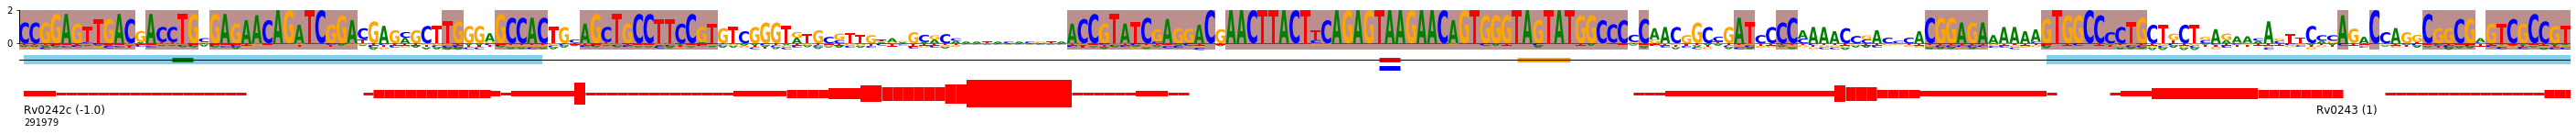

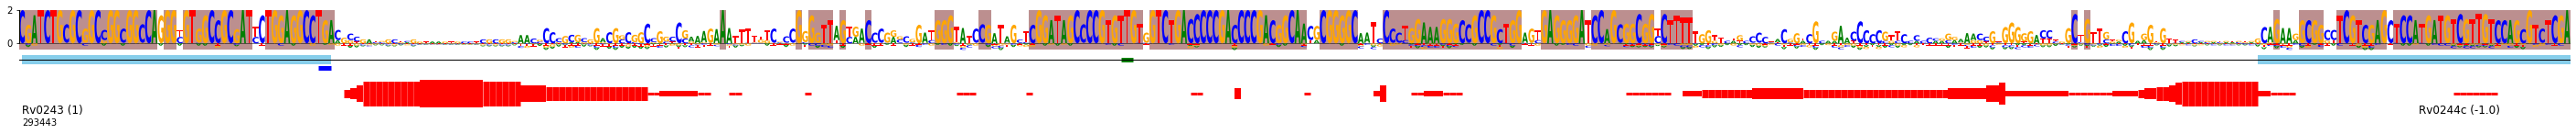

In [20]:
group_id = 1337
  
    #1161 1115 1116 758 1337   1525?List of sRNA in    
    #1129
    #1169 shows upstream start in DeJesus
    #2131 not very well conserved in Arnvig
conservation_plot(group_id, upstream_conservation_info_dictionary)
conservation_plot(group_id, downstream_conservation_info_dictionary)

In [ ]:
data = upstream_conservation_info_dictionary[group_id]
alignment = data[0]; alignment_2 = data[1]; alignment_3 = data[2]; cds_end_pos = data[3]; non_cds_end_pos = data[4]; non_cds_offset_start = data[5]; non_cds_offset_end = data[6]; 
locus_tag = data[7]; cds_strand = data[8]; locus_tag_2 = data[9]; locus_strand_2 = data[10]; utr_start_pos = data[11]; utr_end_pos = data[12]; hmm = data[13]
#plt.plot(alignment.relative_entropy);
#plt.plot(alignment.mvave_relative_entropy);
plt.axvline(x=cds_end_pos, ymin=0, ymax=2, color='r');
plt.axvline(x=non_cds_end_pos, ymin=0, ymax=2, color='r');
for state in [0]:
    plt.plot(hmm.state_probabilities[state]);

In [ ]:
file_ids = util.list_files(non_cds_output_dir+'/')
ids = [int(i.split('.')[0]) for i in file_ids]
for id in tqdm(ids):
    if id in conservation_info_dict:
        temp = conservation_info_dict[id]
        viterbi_path = temp[12].viterbi_path
        viterbi_path_length = len(viterbi_path) 
        conserved_length = sum(viterbi_path[50:viterbi_path_length - 50])
        num_insertions = len(temp[1].master_species_modified_sequence_insertions)
        sequence_length = temp[0].modified_sequence_length
        if sequence_length > 150 and conserved_length > 50:
            print (id, sequence_length, conserved_length, conserved_length/sequence_length, num_insertions)

In [ ]:
temp= seq_data.sequence_data
group_id = (temp[temp['locus_tag'] == 'Rv0243'].iloc[0]['group_id'])
temp[temp['group_id'] == group_id]

In [ ]:
temp= seq_data.sequence_data
temp[temp['group_id'] == 1121]


In [ ]:
temp = orthologs.single_copy_orthologs_df
temp[temp['group_id'] == 1121]